features: tensor([-0.0728, -0.4600]) 
label: tensor([5.6013])
tensor([[ 0.7426,  0.7110],
        [ 0.3029,  1.0750],
        [-0.2062,  0.6010],
        [ 2.1938, -1.7581],
        [ 0.9087, -0.1060],
        [ 0.8437,  0.5192],
        [-0.9408,  0.3576],
        [ 0.7963,  0.7103],
        [ 0.7773, -0.0335],
        [-0.4998,  0.8192]]) 
 tensor([[ 3.2863],
        [ 1.1290],
        [ 1.7478],
        [14.5821],
        [ 6.3773],
        [ 4.1215],
        [ 1.0976],
        [ 3.3806],
        [ 5.8587],
        [ 0.4147]])
epoch 1, loss 0.042029
epoch 2, loss 0.000167
epoch 3, loss 0.000050


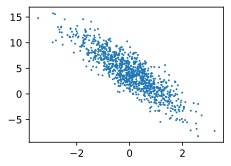

In [5]:
#0开始实现
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))   #均值为0,方差为1,大小为num_examples，列数为len(w)
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0],'\nlabel:', labels[0])

d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1);
#将features的第1列数据与labels做图

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)  #随机打乱下标
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        #用yield返回值后，可以继续运行函数
        #把tensor作为下标，取得值也是tensor

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

In [6]:
#简洁实现
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

# `nn` 是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000169
epoch 2, loss 0.000098
epoch 3, loss 0.000098
w的估计误差： tensor([0.0006, 0.0005])
b的估计误差： tensor([-1.9073e-06])
